In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot

import seaborn as sns
import os

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# ignore harmless warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("drive/MyDrive/kalbe dataset")

# Load data and data cleansing

In [5]:
product = pd.read_csv('Product.csv', sep=';')
customer = pd.read_csv('Customer.csv', sep=';')
transaction = pd.read_csv('Transaction.csv', sep=';')
store = pd.read_csv('Store.csv', sep=';')

### product

In [6]:
product.head()

ProductID   Product Name  Price
0        P1      Choco Bar   8800
1        P2  Ginger Candy    3200
2        P3       Crackers   7500
3        P4    Potato Chip  12000
4        P5       Thai Tea   4200

In [7]:
product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


In [8]:
product.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

### customer

In [9]:
customer.head()

CustomerID  Age  Gender Marital Status Income
0           1   55       1        Married   5,12
1           2   60       1        Married   6,23
2           3   32       1        Married   9,17
3           4   31       1        Married   4,87
4           5   58       1        Married   3,57

In [10]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [11]:
customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [12]:
customer["Gender"] = customer['Gender'].astype('object')

In [13]:
customer['Income'] = customer['Income'].replace(',','.',regex=True)

In [14]:
customer["Income"] = customer['Income'].astype(float)

In [15]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    object 
 3   Marital Status  444 non-null    object 
 4   Income          447 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 17.6+ KB


In [16]:
# fill missing value with the most frequent value of that column
customer['Marital Status']=customer['Marital Status'].fillna(customer['Marital Status'].mode()[0])

In [17]:
customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

### transaction

In [18]:
transaction.head()

TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0       TR11369         328  01/01/2022        P3   7500    4        30000   
1       TR16356         165  01/01/2022        P9  10000    7        70000   
2        TR1984         183  01/01/2022        P1   8800    4        35200   
3       TR35256         160  01/01/2022        P1   8800    7        61600   
4       TR41231         386  01/01/2022        P9  10000    1        10000   

   StoreID  
0       12  
1        1  
2        4  
3        4  
4        4

In [19]:
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [20]:
transaction.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [21]:
transaction['Date']=pd.to_datetime(transaction['Date'])

### store

In [22]:
store.head()

StoreID         StoreName GroupStore           Type   Latitude   Longitude
0        1     Prima Tendean      Prima   Modern Trade       -6,2  106,816666
1        2  Prima Kelapa Dua      Prima   Modern Trade  -6,914864  107,608238
2        3        Prima Kota      Prima   Modern Trade  -7,797068  110,370529
3        4       Gita Ginara       Gita  General Trade  -6,966667  110,416664
4        5           Bonafid       Gita  General Trade  -7,250445  112,768845

In [23]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   StoreID     14 non-null     int64 
 1   StoreName   14 non-null     object
 2   GroupStore  14 non-null     object
 3   Type        14 non-null     object
 4   Latitude    14 non-null     object
 5   Longitude   14 non-null     object
dtypes: int64(1), object(5)
memory usage: 800.0+ bytes


In [24]:
store.isnull().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

# Merging all data

In [25]:
df_merged = pd.merge(transaction, product, on='ProductID', how='left')
df_merged = pd.merge(df_merged, store, on='StoreID', how='left')
df_merged = pd.merge(df_merged, customer, on='CustomerID', how='left')

# Data preparation

In [26]:
df = df_merged.groupby('Date').agg({'Qty':'sum'})

In [27]:
df

Qty
Date           
2022-01-01   49
2022-01-02   50
2022-01-03   76
2022-01-04   98
2022-01-05   67
...         ...
2022-12-27   70
2022-12-28   68
2022-12-29   42
2022-12-30   44
2022-12-31   37

[365 rows x 1 columns]

<Axes: xlabel='Date'>

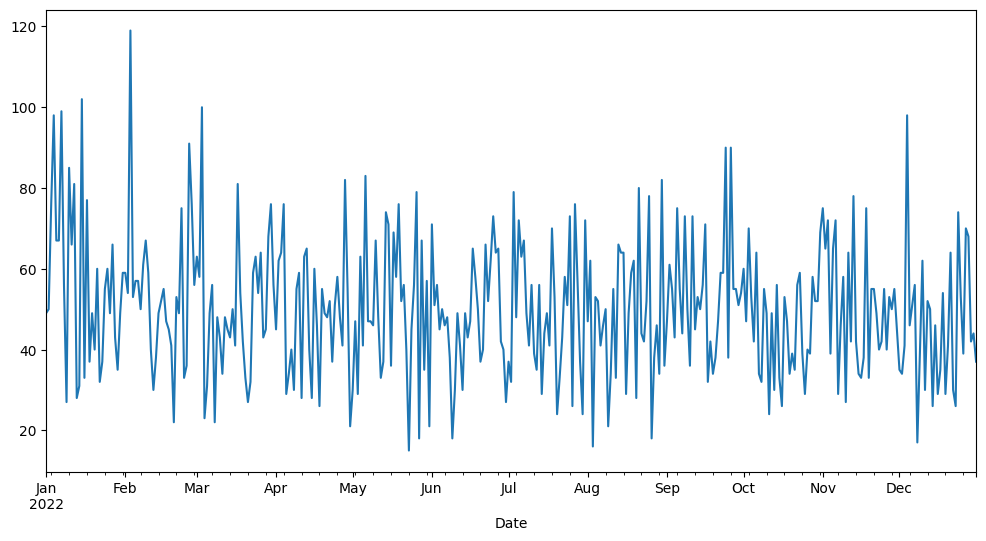

In [28]:
df['Qty'].plot(figsize=(12,6))

## Check Stationarity

In [29]:
X = df['Qty'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.018783
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


p-value <= 0.05: the data does not have a unit root and **is stationary**.

# Modelling

Figure out order for ARIMA model

In [30]:
auto_arima_model = pm.auto_arima(df['Qty'],
                                 seasonal=False,
                                 stepwise=False,
                                 trace=True,
                                 suppress_warnings=True)
auto_arima_model.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3933.778, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3688.453, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3567.999, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3492.571, Time=0.60 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=3418.983, Time=1.04 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=3390.160, Time=1.82 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3330.761, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3103.284, Time=0.95 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3105.214, Time=1.48 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3108.195, Time=0.72 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=3107.018, Time=1.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3232.248, Time=0.16 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3105.211, Time=0.81 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3106.213, Time=1.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3108.211, Time=1.25 sec
 ARIMA(3,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1548.642
Date:                Wed, 08 Nov 2023   AIC                           3103.284
Time:                        14:54:23   BIC                           3114.984
Sample:                    01-01-2022   HQIC                          3107.934
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   4.52e-05   2.21e+04      0.000       1.000       1.000
ma.L1         -0.9827      0.014    -72.182      0.000      -1.009      -0.956
sigma2       279.3379     20.612     13.552      0.000     238.939     319.736
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                10.35
Prob(Q):                              0.68   Prob(JB):                         0.01
Heteroskedasticity (H):               0.68   Skew:                             0.39
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Split dataset

In [31]:
train_size = int(len(df['Qty']) * 0.8)
train_data = df['Qty'][:train_size]
test_data = df['Qty'][train_size:]
print(train_data.shape,test_data.shape)

(292,) (73,)


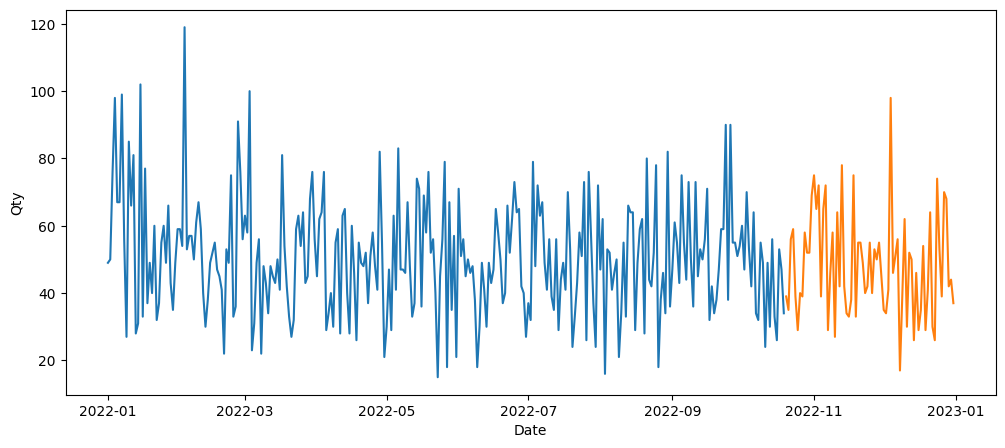

In [32]:
# visualize
plt.figure(figsize=(12,5))
sns.lineplot(data=train_data, x=train_data.index, y=train_data)
sns.lineplot(data=test_data, x=test_data.index, y=test_data)
plt.show()

## Train the model

In [33]:
model = ARIMA(train_data, order=(1,0,1))
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Qty   No. Observations:                  292
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1240.473
Date:                Wed, 08 Nov 2023   AIC                           2488.946
Time:                        14:54:23   BIC                           2503.653
Sample:                    01-01-2022   HQIC                          2494.837
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.6358      1.055     48.009      0.000      48.569      52.703
ar.L1         -0.9861      0.036    -27.118      0.000      -1.057      -0.915
ma.L1          0.9754      0.049     19.707      0.000       0.878       1.072
sigma2       286.6478     21.811     13.142      0.000     243.899     329.397
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                23.73
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.59
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict on test set

In [34]:
start = len(train_data)
end = len(train_data)+len(test_data)-1
pred = model.predict(start=start,end=end,typ='levels')
print(pred)

2022-10-20    51.424681
2022-10-21    49.857847
2022-10-22    51.402870
2022-10-23    49.879355
2022-10-24    51.381662
                ...    
2022-12-27    50.939891
2022-12-28    50.335889
2022-12-29    50.931483
2022-12-30    50.344180
2022-12-31    50.923307
Freq: D, Name: predicted_mean, Length: 73, dtype: float64


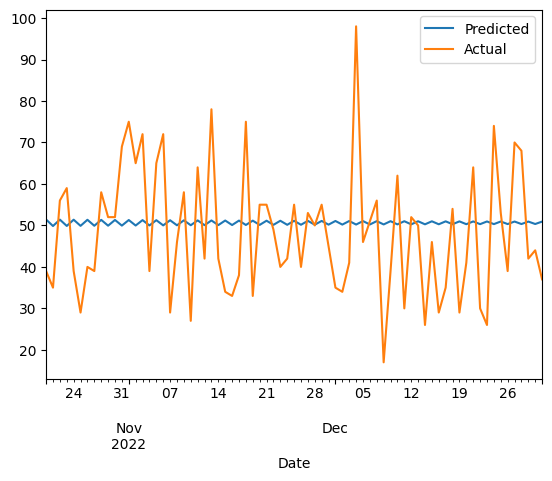

In [35]:
pred.plot(label='Predicted')
test_data.plot(label='Actual')

plt.legend()
plt.show()

In [36]:
rmse = sqrt(mean_squared_error(test_data,pred))
print(rmse)

15.49482859020857


# Improvement: Grid Search ARIMA

In [37]:
# Evaluate an ARIMA model for a given order (p, d, q)
def evaluate_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = int(len(df['Qty']) * 0.8)
    train_data, test_data = df['Qty'][:train_size], df['Qty'][train_size:]
    history = [x for x in train_data]

    # Make predictions
    predictions = list()
    for t in range(len(test_data)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test_data[t])

    # Calculate out-of-sample error
    rmse = sqrt(mean_squared_error(test_data, predictions))
    return rmse

In [38]:
# Evaluate combinations of p, d, and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order, rmse))
                except:
                    continue

    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# Evaluate parameters
p_values = [6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)

warnings.filterwarnings("ignore")
evaluate_models(df['Qty'].values, p_values, d_values, q_values)

ARIMA(6, 0, 0) RMSE=15.713
ARIMA(6, 0, 1) RMSE=15.755
ARIMA(6, 0, 2) RMSE=15.840
ARIMA(6, 1, 0) RMSE=16.556
ARIMA(6, 1, 1) RMSE=15.681
ARIMA(6, 1, 2) RMSE=15.645
ARIMA(6, 2, 0) RMSE=19.598
ARIMA(6, 2, 1) RMSE=16.592
ARIMA(6, 2, 2) RMSE=16.630
ARIMA(8, 0, 0) RMSE=15.683
ARIMA(8, 0, 1) RMSE=15.686
ARIMA(8, 1, 0) RMSE=16.172
ARIMA(8, 1, 1) RMSE=15.659
ARIMA(8, 1, 2) RMSE=15.669
ARIMA(8, 2, 0) RMSE=18.021
ARIMA(8, 2, 1) RMSE=16.217
ARIMA(8, 2, 2) RMSE=16.298
ARIMA(10, 0, 0) RMSE=15.596
ARIMA(10, 0, 1) RMSE=15.710
ARIMA(10, 0, 2) RMSE=15.683
ARIMA(10, 1, 0) RMSE=16.298
ARIMA(10, 1, 1) RMSE=15.556
ARIMA(10, 1, 2) RMSE=15.568
ARIMA(10, 2, 0) RMSE=17.807
ARIMA(10, 2, 1) RMSE=16.339
ARIMA(10, 2, 2) RMSE=16.412
Best ARIMA(10, 1, 1) RMSE=15.556


# Forecast for all product

In [39]:
product_reg_df = df_merged[['Qty', 'Date', 'Product Name']]
new = product_reg_df.groupby("Product Name")

forecast_product_df = pd.DataFrame({'Date': pd.date_range(start='2023-01-01', periods=90)})

for product_name, group_data in new:
    target_var = group_data['Qty']
    model = ARIMA(target_var.values, order=(2,0,1))
    model_fit = model.fit()
    forecast = model_fit.forecast(90)
    forecast_product_df[product_name] = forecast

forecast_product_df.set_index('Date', inplace=True)
forecast_product_df.head()

Cashew  Cheese Stick  Choco Bar  Coffee Candy  Crackers  \
Date                                                                    
2023-01-01  2.645827      2.939882   5.407618      4.010693  3.594209   
2023-01-02  2.363435      3.020074   6.522126      3.835101  3.453006   
2023-01-03  2.468882      3.016513   5.746719      4.095557  3.510425   
2023-01-04  2.452850      3.016235   6.285347      4.001687  3.516951   
2023-01-05  2.459680      3.015832   5.911353      4.017073  3.514614   

            Ginger Candy        Oat  Potato Chip  Thai Tea   Yoghurt  
Date                                                                  
2023-01-01       4.851767  1.923303     2.875925  3.464230  4.111065  
2023-01-02       4.934113  2.049793     2.811028  3.530315  3.924237  
2023-01-03       4.952584  2.003712     2.809367  3.494389  4.060268  
2023-01-04       4.954285  1.987711     2.800209  3.509171  4.003408  
2023-01-05       4.954687  1.988530     2.802315  3.503219  4.031104

In [40]:
#Products Quantity forecast
round(forecast_product_df.describe().T['mean'],0)

Cashew           2.0
Cheese Stick     3.0
Choco Bar        6.0
Coffee Candy     4.0
Crackers         4.0
Ginger Candy     5.0
Oat              2.0
Potato Chip      3.0
Thai Tea         4.0
Yoghurt          4.0
Name: mean, dtype: float64

# Future Improvement

*   Rolling forecast
*   Other methods: Manual ARIMA, Exponential Smoothing (ES), Simple ES

